In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [4]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from PIL import Image
from collections import OrderedDict
from scipy.stats import pearsonr
import squidpy as sq
import timm
import itertools
import anndata as ad
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools
from collections import Counter
import muon as mu

In [3]:
from pipelines.load import LoadCytAssistPipeline, LoadVisiumPipeline, LoadSeuratTonsilsPipeline
from pipelines.featurize import FeaturizePipeline
from pipelines.train import TrainModelPipeline
from pipelines.infer import InferencePipeline

from utils import cluster, align_adata, column_corr, floatify, tocpu, alpha_shape
from utils import alpha_shape

In [5]:
citeseq = sc.read_h5ad('/ihome/hosmanbeyoglu/kor11/tools/SPICESS/data/tonsil_atlas_citeseq.h5ad')
df = pd.read_csv('/ihome/hosmanbeyoglu/kor11/tools/SPICESS/data/adt.csv', index_col=0)
sc.pp.normalize_total(citeseq, target_sum=1e4)
citeseq.var['mt'] = citeseq.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(citeseq, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
mu.pp.filter_obs(citeseq, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
mu.pp.filter_obs(citeseq, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(citeseq, 'pct_counts_mt', lambda x: x < 20)

In [16]:
tissue = 'Tonsil'
antibody_panel = pd.read_csv('/ihome/hosmanbeyoglu/kor11/tools/wrapup/SPICESS/antibody_panel.csv')
# adata_annot = sc.read_h5ad("../adata/tonsil_cytassist.h5ad")
data_path = '/ihome/hosmanbeyoglu/kor11/tools/SPICESS/data/TonsilTissue'
gc_pth = 'https://raw.githubusercontent.com/vitkl/cell2location_paper/master/notebooks/selected_results/lymph_nodes_analysis/manual_GC_annot.csv'
dfc = pd.read_csv(gc_pth).fillna('Other')
dfc.columns = ['Barcode', 'GroundTruth GC']
dfc['GroundTruth GC'] = dfc['GroundTruth GC'].astype('category')
data_path = '/ihome/hosmanbeyoglu/kor11/tools/SPICESS/data/TonsilTissue'

train_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = 'Tonsil 1',
    # celltypes = adata_annot.obs.celltype
)

eval_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    sample_id = 1,
    name = 'Tonsil 2',
)

test_loader = LoadVisiumPipeline(
    tissue=tissue, 
    visium_dir=data_path+'/GEX', 
    sample_id=2, 
    name='ST Only'
)

Created 10x Visium data loader pipeline.


In [31]:
adata, pdata = train_loader.run() 
adata_eval, pdata_eval = eval_loader.run()
adata_test = test_loader.run()
adata_test.obs = adata_test.obs.join(dfc.set_index('Barcode'))

adata.shape, pdata.shape, adata_eval.shape, pdata_eval.shape, adata_test.shape

((4194, 18074), (4194, 30), (4908, 18074), (4908, 30), (4035, 36601))

In [32]:
sc.pp.filter_genes(adata, min_cells=5, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
adata = adata[:, (adata.var['highly_variable'] | adata.var_names.isin(['PTPRC']+list(pdata.var_names)))]
adata.X = adata.layers['counts']

adata_eval = align_adata(adata_eval, adata)
adata_test = align_adata(adata_test, adata)

In [39]:
trainer = TrainModelPipeline(
    tissue = 'Tonsil',
    adatas = [adata, adata_eval],
    pdatas = [pdata, pdata_eval],
    repeats = 10,
    latent_dim = 512,
    save = False,
    lr = 2e-5,
    dropout=0.1,
    use_histology=True,
    patience = 100,
    epochs = 9000,
    recons_gex = 1e-4, 
    recons_pex = 1e-4, 
    adj = 1e-3,
    align = 1e-4,
    minmax_vertical = True,
    min_max = True,
    gene_log = True,
    protein_log = False
)

spicess = trainer.run()

Created training pipeline.


Imput: 0.584 | SelfImput: 0.692 | Loss: 245 | Align: 0.00156 | : 100%|██████████| 6000/6000 [56:02<00:00,  1.78it/s, 1516d -> 512d || 0/100]  


In [42]:
spicess.iter_0.results

,CORR_0
CD163,0.646614
CR2,0.599839
PCNA,0.498297
VIM,0.705277
KRT5,0.805730
CD68,0.463759
CEACAM8,0.261672
PTPRC_1,0.647204
PAX5,0.737572
SDC1,0.172166


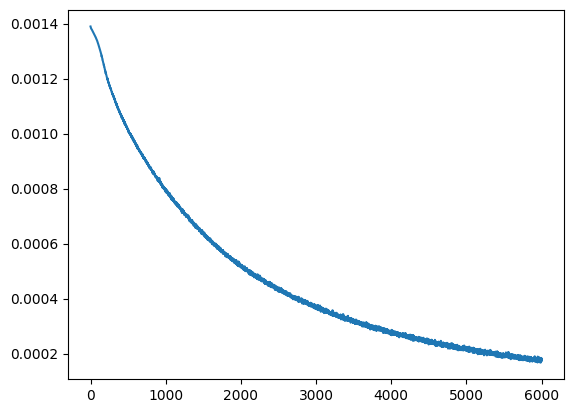

In [49]:
plt.plot(spicess.iter_0.metrics.values.mutual_info_loss)